# Processing of ILAMB datasets and comparison to PPE

# 1. Setup

In [1]:
%load_ext watermark
%load_ext autoreload

import glob
import copy
import pickle

import numpy as np
import pandas as pd
import xarray as xr

from ILAMB import ilamblib
import regionmask as rgn

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

conda environment: ilamb

numpy     : 2.2.4
pandas    : 2.2.2
cartopy   : 0.24.0
ILAMB     : 2.7.2
matplotlib: 3.10.1
cmocean   : 4.0.3
xarray    : 2025.3.0
sys       : 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:48:41) [GCC 13.3.0]
regionmask: 0.13.0



In [2]:
mpl.rcParams['figure.dpi'] = 150

with open('./top26_param_colors.pkl', 'rb') as f:
    pscs26 = list(pickle.load(f).values())

with open('./top12_param_colors.pkl', 'rb') as f:
    pscs12 = list(pickle.load(f).values())

## 1.1. Dask

In [3]:
# Create Dask cluster and client, scale up to 20 workers
# cluster, client = ppe.get_ClusterClient(walltime='02:00:00')
# cluster.scale(20)

In [4]:
## Check the status of the cluster
# client

## Prints the PBS job script that is used to submit the Dask workers
# print(cluster.job_script())

## Lists active workers and their status
# cluster.workers

## Lists current jobs in Casper queue
# !qstat -u $USER

# 2. Load annual mean ET datasets

In [3]:
indir = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed/annual_mean'

et_gleam = xr.open_dataset(f'{indir}/HFLS_ANNUAL_GLEAMv3.3a_ILAMB_20250320.nc')
et_mod16a2 = xr.open_dataset(f'{indir}/HFLS_ANNUAL_MOD16A2_ILAMB_20250320.nc')
et_modis = xr.open_dataset(f'{indir}/HFLS_ANNUAL_MODIS_ILAMB_20250320.nc')
et_dolce = xr.open_dataset(f'{indir}/HFLS_ANNUAL_DOLCE_ILAMB_20250320.nc')
et_class = xr.open_dataset(f'{indir}/HFLS_ANNUAL_CLASS_ILAMB_20250320.nc')
et_wecann = xr.open_dataset(f'{indir}/HFLS_ANNUAL_WECANN_ILAMB_20250320.nc')
et_fluxcom = xr.open_dataset(f'{indir}/HFLS_ANNUAL_FLUXCOM_ILAMB_20250320.nc')

et = {
    'GLEAM': et_gleam,
    'MOD16A2': et_mod16a2,
    'MODIS': et_modis,
    'DOLCE': et_dolce,
    'CLASS': et_class,
    'WECANN': et_wecann.isel(lat=slice(None, None, -1)),  # flip the lat dimension for WECANN
    'FLUXCOM': et_fluxcom
}

# Load the land mask from the Natural Earth dataset
land = rgn.defined_regions.natural_earth_v5_1_2.land_50

# Compute the cell areas for each dataset then extract the ET variable
area = {}
lnd_area = {}
for key, ds in et.items():
    print(key)

    if 'lat_bounds' in ds and 'lon_bounds' in ds:
        print('  using bounds')
        method = 'bounds'
        lat_bounds = ds['lat_bounds'].values
        lon_bounds = ds['lon_bounds'].values
    else:
        print('  could not find bounds, using coordinates instead')
        method = 'coords'
        lat_bounds = None
        lon_bounds = None

    # Compute the cell areas using the ILAMB function
    area[key] = ilamblib.CellAreas(
                    lat=ds['lat'].values,
                    lon=ds['lon'].values,
                    lat_bnds=lat_bounds,
                    lon_bnds=lon_bounds,
                )

    area[key] = xr.DataArray(area[key], dims=['lat', 'lon'], coords={'lat': ds['lat'], 'lon': ds['lon']})
    area[key].attrs['units'] = 'm2'
    area[key].attrs['long_name'] = 'grid cell area'
    area[key].attrs['method'] = method
    
    # Create a land mask for the dataset using the Natural Earth land mask
    lnd_mask = xr.where(np.isnan(land.mask(lon_or_obj=area[key].lon, lat=area[key].lat)), 0, 1)
    lnd_area[key] = area[key] * lnd_mask
    lnd_area[key].attrs['units'] = 'm2'
    lnd_area[key].attrs['long_name'] = 'land grid cell area'
    lnd_area[key].attrs['method'] = method

    # Extract the ET (hfls, latent heat flux) variable from each dataset
    et[key] = ds['hfls'].where(lnd_mask > 0)

GLEAM
  using bounds
MOD16A2
  using bounds
MODIS
  could not find bounds, using coordinates instead
DOLCE
  could not find bounds, using coordinates instead
CLASS
  could not find bounds, using coordinates instead
WECANN
  could not find bounds, using coordinates instead
FLUXCOM
  using bounds


# 3. Compute temporal, zonal, and global means

In [4]:
start_year = 2003
end_year = 2009
year_slice = slice(start_year, end_year)
print(f'{start_year} to {end_year}')

ilat = et['GLEAM'].lat.values  # use the lat values from GLEAM for interpolation

et_savg = {}
et_zavg = {}
et_izavg = {}

# Full temporal averages (all years for each dataset)
et_tavg_full = {}
et_tzavg_full = {}
et_itzavg_full = {}

# Temporal averages for the specified year range (overlapping time period only)
et_tavg_overlap = {}
et_tzavg_overlap = {}
et_itzavg_overlap = {}

for key in et.keys():
    # Compute the global average
    et_savg[key] = (et[key] * lnd_area[key]).sum(dim=['lat', 'lon']) / lnd_area[key].sum(dim=['lat', 'lon'])

    # Compute the zonal averages
    et_zavg[key] = et[key].mean(dim='lon')

    # Interpolate the zonal average to a 1deg lat grid
    et_izavg[key] = et_zavg[key].interp(lat=ilat, method='linear')

    # Compute the temporal average for the full dataset
    et_tavg_full[key] = et[key].mean(dim='year')
    et_tzavg_full[key] = et_tavg_full[key].mean(dim='lon')
    et_itzavg_full[key] = et_tzavg_full[key].interp(lat=ilat, method='linear')
    
    # Compute the temporal average for the specified year range
    if (start_year in et[key].year) and (end_year in et[key].year):
        et_tavg_overlap[key] = et[key].sel(year=year_slice).mean(dim='year')

        # Compute the temporal and zonal average
        et_tzavg_overlap[key] = et_tavg_overlap[key].mean(dim='lon')
        et_itzavg_overlap[key] = et_tzavg_overlap[key].interp(lat=ilat, method='linear')
    else:
        print('skipping temporal average for', key)

# Create a DataArray from the et_itzavg_overlap dictionary
datasets = list(et_itzavg_overlap.keys())
data = [et_itzavg_overlap[ds].values for ds in datasets]
et_itzavg_overlap_da = xr.DataArray(
    data,
    dims=['dataset', 'lat'],
    coords={'dataset': datasets, 'lat': ilat},
    name='et_itzavg_overlap',
    attrs={
        'units': 'W m-2',
        'standard_name': 'latent_heat_flux',
        'long_name': 'latent heat flux',
    }
)

2003 to 2009
skipping temporal average for WECANN


## 3.2 Save to file

In [29]:
OUTDIR_ZM = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed/zonal_mean'
et_itzavg_overlap_da.to_netcdf(f'{OUTDIR_ZM}/HFLS_ZONAL_MEAN_ILAMB_{start_year}-{end_year}.nc')

OUTDIR_GM = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed/global_mean'
for key in et_savg.keys():
    et_savg[key].rename(f'hfls_{key}').to_netcdf(f'{OUTDIR_GM}/HFLS_GLOBAL_MEAN_{key}_ILAMB.nc')

In [32]:
# INDIR_ILAMB = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed'
# ilamb_zm = xr.open_dataset(f'{INDIR_ILAMB}/zonal_mean/HFLS_ZONAL_MEAN_ILAMB_2003-2009.nc')
# ilamb_gm = {}
# for f in glob.glob(INDIR_ILAMB + '/global_mean/*.nc'):
#     key = f.split('/')[-1].split('_')[3]
#     ilamb_gm[key] = xr.open_dataset(f)

# 4. Plot

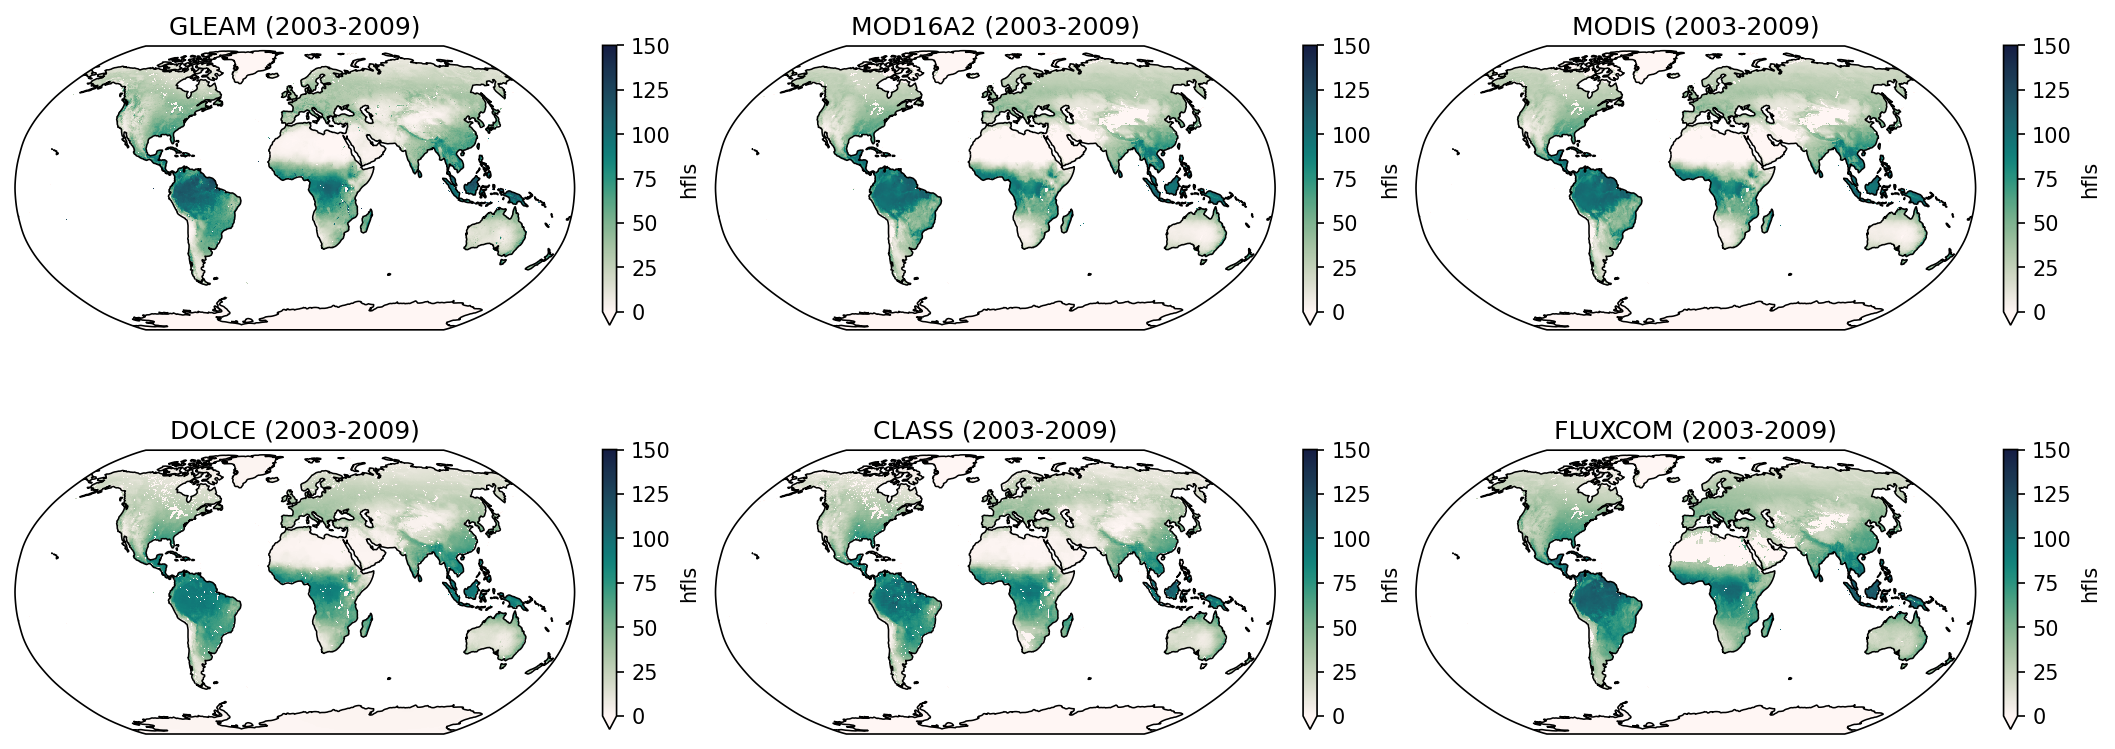

In [245]:
fig, axs = plt.subplots(3, 3, figsize=(14, 8), subplot_kw={'projection': ccrs.Robinson()}, layout='constrained')
ax = axs.flatten()

for i, (name, da) in enumerate(et_tavg_overlap.items()):
    da.plot(ax=ax[i], transform=ccrs.PlateCarree(), cbar_kwargs={'fraction': 0.025}, extend='min', cmap=cmo.tempo, vmin=0, vmax=150)
    ax[i].set_title(f'{name.upper()} ({start_year}-{end_year})', fontsize=12)
    ax[i].coastlines(lw=0.75)

for i in range(1, 10-len(et_tavg_overlap)):
    ax[-i].remove()

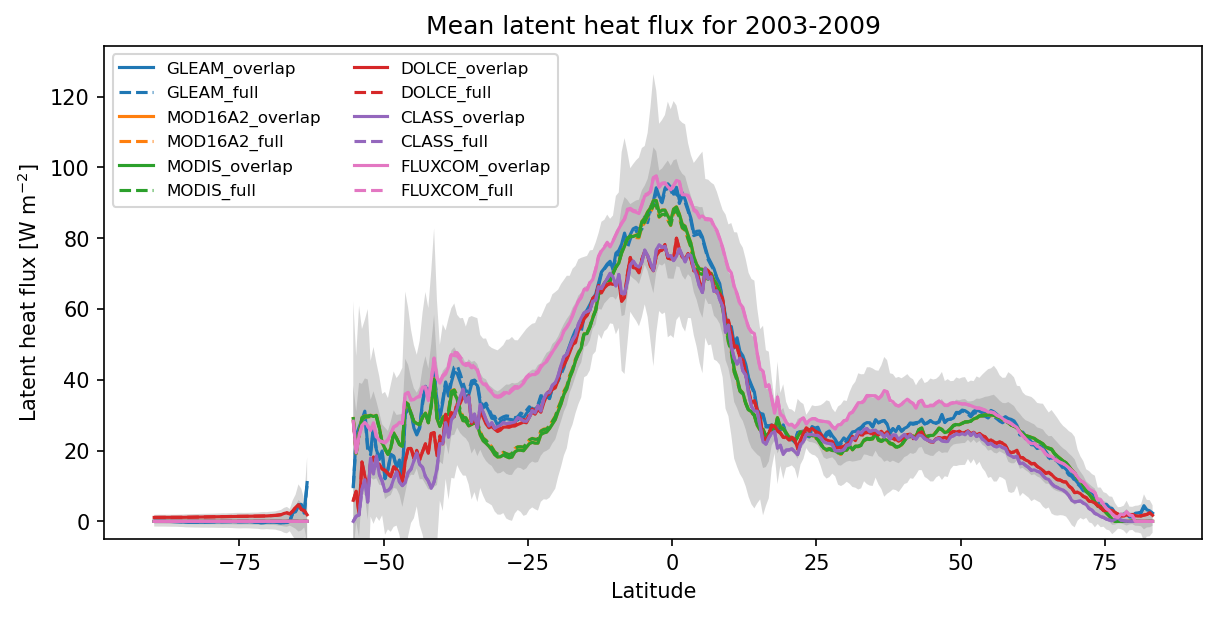

In [272]:
et_max = et_itzavg_overlap_da.max(dim='dataset')
et_min = et_itzavg_overlap_da.min(dim='dataset')
mean = et_itzavg_overlap_da.mean(dim='dataset')
stddev = et_itzavg_overlap_da.std(dim='dataset')

fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
cs = list(mpl.colors.TABLEAU_COLORS)

for i, key in enumerate(et.keys()):
    if key in et_itzavg_overlap.keys():
        et_tzavg_overlap[key].plot(ax=ax, label=key.upper()+'_overlap', c=cs[i], lw=1.5, ls='-')
        et_tzavg_full[key].plot(ax=ax, label=key.upper()+'_full', c=cs[i], lw=1.5, ls='--')

ax.fill_between(
    ilat,
    mean-2*stddev,
    mean+2*stddev,
    color='gray',
    alpha=0.3,
    linewidth=0,
)

ax.fill_between(
    ilat,
    mean-4*stddev,
    mean+4*stddev,
    color='gray',
    alpha=0.3,
    linewidth=0,
)
ax.set_ylim(-5, None)
ax.set_title(f'Mean latent heat flux for {start_year}-{end_year}', fontsize=12)
ax.set_ylabel('Latent heat flux [W m$^{-2}$]')
ax.set_xlabel('Latitude')
ax.legend(ncol=2, loc='upper left', fontsize=8)

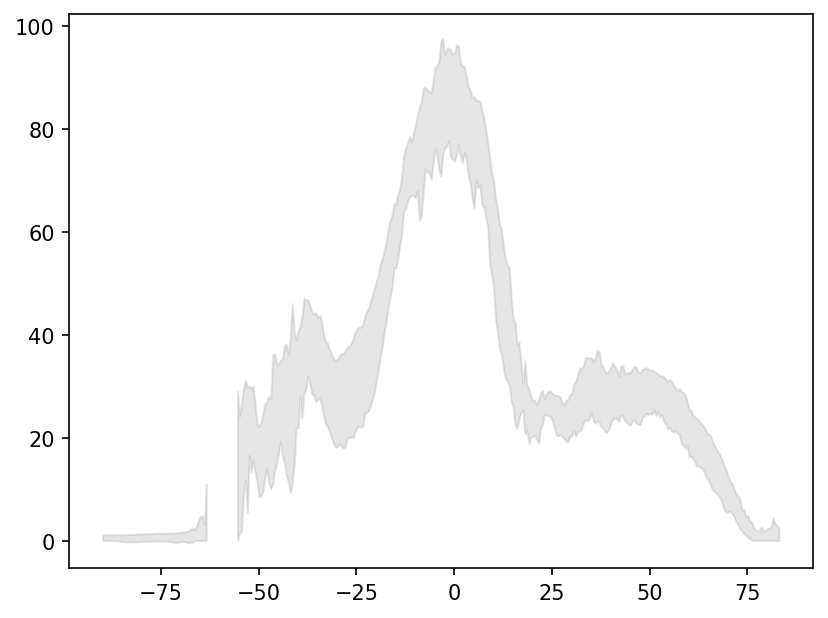

In [247]:
et_max = et_itzavg_overlap_da.max(dim='dataset')
et_min = et_itzavg_overlap_da.min(dim='dataset')

plt.fill_between(
    ilat,
    et_min,
    et_max,
    color='gray',
    alpha=0.2,
    label='min-max range'
)

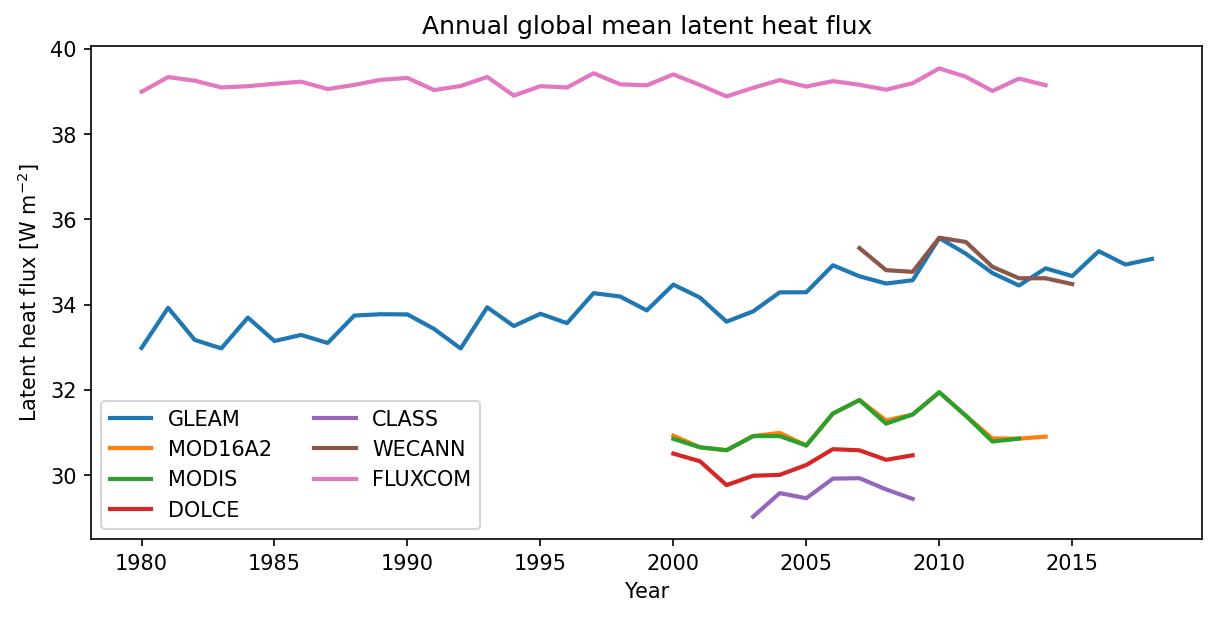

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
cs = list(mpl.colors.TABLEAU_COLORS)

for i, key in enumerate(et.keys()):
    et_savg[key].plot(ax=ax, label=key.upper(), c=cs[i], lw=2)
ax.set_title('Annual global mean latent heat flux', fontsize=12)
ax.set_ylabel('Latent eat flux [W m$^{-2}$]')
ax.set_xlabel('Year')
ax.legend(ncol=2, loc='lower left', fontsize=10)

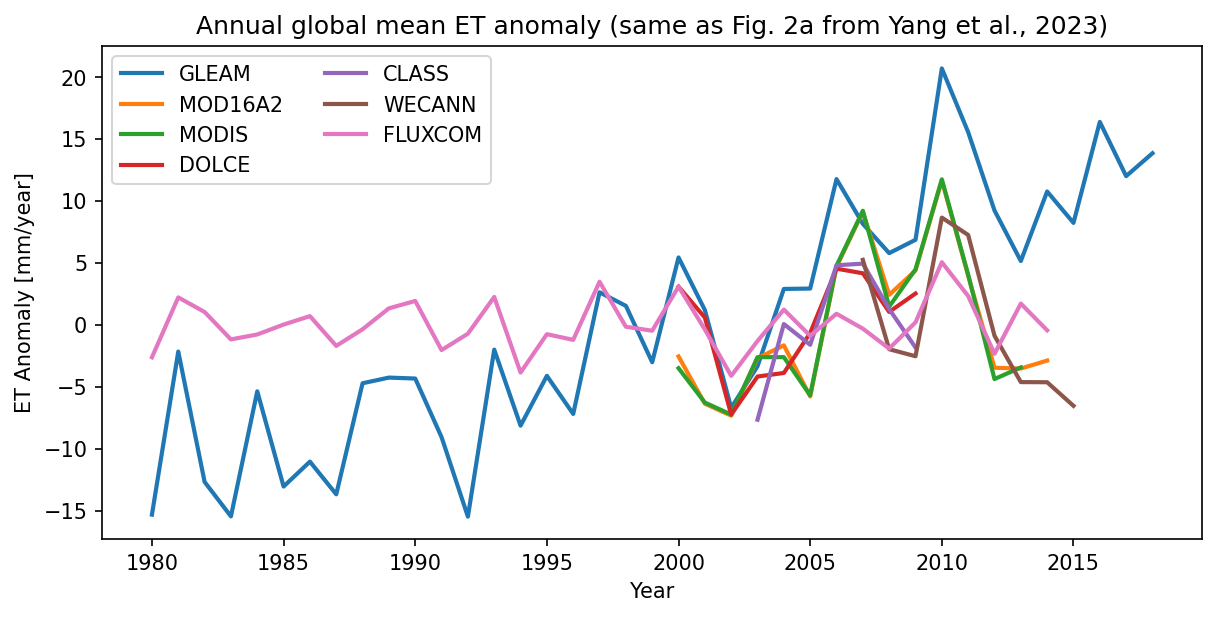

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
cs = list(mpl.colors.TABLEAU_COLORS)

for i, key in enumerate(sorted(et.keys())):
    ((et_savg[key] - et_savg[key].mean(dim='year')) / 2.26e6 * 60 * 60 * 24 * 365).plot(ax=ax, label=key.upper(), c=cs[i], lw=2)
ax.set_title('Annual global mean ET anomaly (same as Fig. 2a from Yang et al., 2023)', fontsize=12)
ax.set_ylabel('ET Anomaly [mm/year]')
ax.set_xlabel('Year')
ax.legend(ncol=2, loc='upper left', fontsize=10)

# !! KILL DASK !!

(don't want to get spammed with PBS emails when the workers time out)

In [ ]:
# client.shutdown()
# !rm ./dask-worker.e*
# !rm ./dask-worker.o*